In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import data_path

In [3]:
df_option = pd.read_parquet(os.path.join(data_path,'SPY_new.parquet'))

In [ ]:
df_option = df_option[
    (df_option['open_interest'] > 0) &
    #(df_option['gamma'].notnull()) &  # 防止 NaN
    (df_option['best_bid'] > 0) &
    (df_option['best_offer'] > 0) &
    df_option['cp_flag'].isin(['C', 'P'])
]

df_option ['mid_price'] = (df_option ['best_bid'] + df_option ['best_offer']) / 2

df_option['date'] = pd.to_datetime(df_option['date'])
df_option = df_option[df_option['date']>='2011-01-01']

df_option

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,mid_price
2537962,109820,2011-01-03,SPY 110107C118000,1,2011-01-07,2010-12-30,C,118000,9.06,9.19,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,9.125
2537963,109820,2011-01-03,SPY 110107C119000,1,2011-01-07,2011-01-03,C,119000,8.06,8.20,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,8.130
2537964,109820,2011-01-03,SPY 110107C120000,1,2011-01-07,2011-01-03,C,120000,7.08,7.14,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,7.110
2537965,109820,2011-01-03,SPY 110107C121000,1,2011-01-07,2011-01-03,C,121000,6.09,6.15,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,6.120
2537966,109820,2011-01-03,SPY 110107C122000,1,2011-01-07,2011-01-03,C,122000,5.10,5.16,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,5.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20275047,109820,2022-12-30,SPY 251219P370000,1,2025-12-19,2022-12-29,P,370000,38.00,43.00,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,40.500
20275048,109820,2022-12-30,SPY 251219P375000,1,2025-12-19,2022-12-30,P,375000,40.00,45.00,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,42.500
20275049,109820,2022-12-30,SPY 251219P380000,1,2025-12-19,2022-12-30,P,380000,44.00,47.00,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,45.500
20275057,109820,2022-12-30,SPY 251219P420000,1,2025-12-19,2022-12-30,P,420000,60.00,65.00,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,62.500


In [5]:
import yfinance as yf
import ta 

spy = yf.download("SPY", start="2011-05-02", end="2025-04-04")
df_spy = spy[['Close']].rename(columns={'Close': 'SPY'})
df_spy = df_spy['SPY']
df_spy.dropna(inplace=True)
df_spy = df_spy.reset_index().rename(columns={'Date': 'date', 'SPY': 'SPY'})


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df_spy['date'] = pd.to_datetime(df_spy['date'])

In [8]:
df_merged = pd.merge(df_option,df_spy,on='date')
df_merged = df_merged[['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'mid_price', 'SPY',
                       'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
                       'contract_size']]
df_merged.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,mid_price,SPY,volume,open_interest,impl_volatility,delta,gamma,vega,theta,contract_size
0,2011-05-02,2011-05-06,C,126000,10.19,10.33,10.26,105.57206,0,113,0.364297,0.980543,0.009114,0.675369,-11.44478,100
1,2011-05-02,2011-05-06,C,127000,9.19,9.33,9.26,105.57206,0,104,0.332588,0.978891,0.010697,0.722552,-11.20204,100
2,2011-05-02,2011-05-06,C,128000,8.20,8.32,8.26,105.57206,0,3,0.300755,0.976909,0.012761,0.778696,-10.93411,100
3,2011-05-02,2011-05-06,C,129000,7.21,7.33,7.27,105.57206,28,28,0.279665,0.969663,0.017234,0.981348,-12.73111,100
4,2011-05-02,2011-05-06,C,130000,6.21,6.31,6.26,105.57206,73,120,0.236426,0.971413,0.019406,0.933826,-10.29165,100


In [10]:
df_merged['gamma_exposure'] = df_merged['gamma'] *  100 * df_merged['open_interest'] * df_merged['SPY']**2 * 0.01

In [11]:
call_gamma = df_merged[df_merged['cp_flag'] == 'C'].groupby('date')['gamma_exposure'].sum()
put_gamma = df_merged[df_merged['cp_flag'] == 'P'].groupby('date')['gamma_exposure'].sum()

gamma_exposure = pd.DataFrame({'GEX': call_gamma - put_gamma,'GEX_Skew': (call_gamma - put_gamma)/(call_gamma + put_gamma)}).reset_index()
gamma_exposure.head()

,date,GEX,GEX_Skew
0,2011-05-02,-5.252033e+08,-0.098490
1,2011-05-03,-1.022093e+09,-0.173401
2,2011-05-04,-1.463760e+09,-0.237118
3,2011-05-05,-1.844784e+09,-0.301160
4,2011-05-06,-1.428730e+09,-0.252992


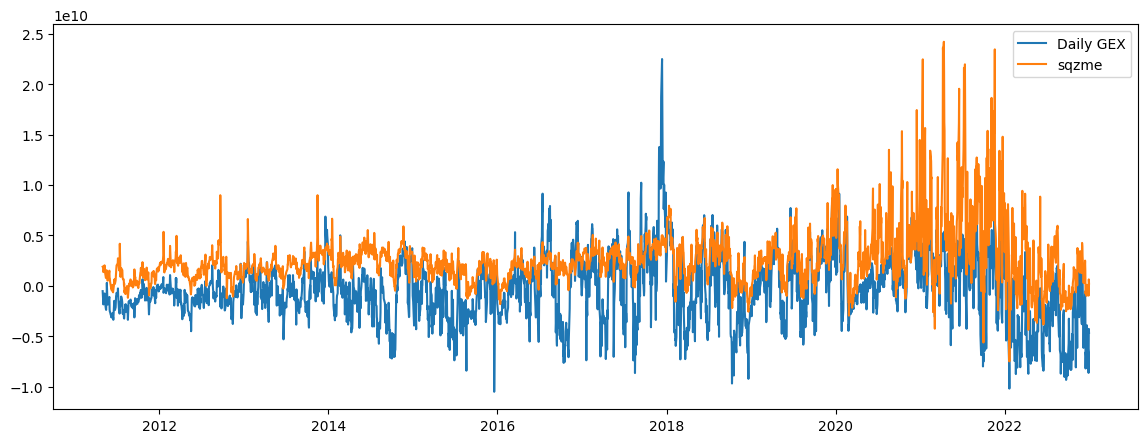

In [13]:
gex_df = gamma_exposure.copy()

df_sq = pd.read_csv(os.path.join(data_path, 'sqzme.csv'))
df_sq['date'] = pd.to_datetime(df_sq['date'])
df_sq = df_sq[df_sq['date'] <= '2022-12-31']

gex_sq = df_sq.rename(columns={'gex':'gex_sq'})
gex_sq = gex_sq[['date','gex_sq']]
gex_sq['date'] = pd.to_datetime(gex_sq['date'])

plt.figure(figsize=(14, 5))


plt.plot(gex_df['date'],gex_df['GEX'], label='Daily GEX')

plt.plot(gex_sq['date'],gex_sq['gex_sq'], label='sqzme')

plt.title('')
plt.legend()
plt.show()
